<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Salary/Salary_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm
!pip install --upgrade lightgbm
!pip install pycountry_convert
!pip install "dask[dataframe]"


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import MiniBatchKMeans
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pycountry_convert as pc
from collections import Counter

import xgboost as xgb
import lightgbm as lgb
import requests
import io

import re


In [55]:
# Define the base URL and the download path
base_url = "https://aijobs.net"
download_path = "/salaries/download/salaries.csv"

# Construct the full URL for the CSV file
download_url = base_url + download_path

# Send a GET request to download the file
response = requests.get(download_url, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    print("File downloaded successfully. Loading into DataFrame...")

    # Read the CSV file directly into a pandas DataFrame from the response content
    data = pd.read_csv(io.StringIO(response.text))

    # Print general dataset information
    print("\n🔹 Dataset Overview:")
    print(f"Shape: {data.shape}")  # Number of rows and columns
    print(f"Columns: {data.columns.tolist()}")  # Column names
    print("\n🔹 Data Types and Missing Values:")
    print(data.info())  # Data types and non-null counts
    print("\n🔹 Statistical Summary:")
    print(data.describe())  # Summary statistics for numerical columns

else:
    print(f"Failed to download file. Status code: {response.status_code}")


File downloaded successfully. Loading into DataFrame...

🔹 Dataset Overview:
Shape: (81388, 11)
Columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

🔹 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81388 entries, 0 to 81387
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           81388 non-null  int64 
 1   experience_level    81388 non-null  object
 2   employment_type     81388 non-null  object
 3   job_title           81388 non-null  object
 4   salary              81388 non-null  int64 
 5   salary_currency     81388 non-null  object
 6   salary_in_usd       81388 non-null  int64 
 7   employee_residence  81388 non-null  object
 8   remote_ratio        81388 non-null  int64 
 9   company_location    81388 non-nul

In [56]:
data = data.drop(columns=["salary", "salary_currency"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employment_type: 4 unique values
employee_residence: 95 unique values
company_location: 89 unique values
company_size: 3 unique values
job_title: 300 unique values
remote_ratio: 3 unique values


In [57]:
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min:,.2f}")
print(f"Maximum Salary: {salary_max:,.2f}")
print(f"Mean Salary: {salary_mean:,.2f}")
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std:,.2f}")


Minimum Salary: 15,000.00
Maximum Salary: 800,000.00
Mean Salary: 157,878.17
Standard Deviation of Salary: 73,206.24


In [58]:
# Define target variable
y = data["salary_in_usd"]

# Define feature set (keeping full dataset without simplifications)
X = data.drop(columns=["salary_in_usd"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables using One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Ensure train and test sets have the same columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Confirm dataset shape
print(f"✅ Train set: {X_train_encoded.shape} | Test set: {X_test_encoded.shape}")


✅ Train set: (65110, 499) | Test set: (16278, 499)


Naive model

In [59]:
# Function to evaluate model performance
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    std_dev = np.std(y_true)  # Standard deviation of actual values
    rmse_sigma_ratio = rmse / std_dev  # RMSE relative to standard deviation

    print(f"📊 {model_name} Performance:")
    print(f"MAE: {mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:,.2f}")
    print(f"RMSE / σ Ratio: {rmse_sigma_ratio:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)

    return {"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse, "RMSE / σ Ratio": rmse_sigma_ratio, "R²": r2}


In [60]:
# Compute baseline prediction (mean salary)
baseline_prediction = np.mean(y_train)

baseline_results = evaluate_model("Basline Prediction", y_test, [baseline_prediction] * len(y_test))


📊 Basline Prediction Performance:
MAE: 56,239.89
MAPE: 48.94%
RMSE: 73,347.27
RMSE / σ Ratio: 1.00
R²: -0.0001
--------------------------------------------------


In [61]:
# Train Linear Regression on the full dataset
print(f"🚀 Training Linear Regression on full dataset...")

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test_encoded)

# Evaluate model
lr_results = evaluate_model("Linear Regression (Full Data)", y_test, y_pred)

# Convert results into a DataFrame for easy reference
lr_results_df = pd.DataFrame([lr_results])



🚀 Training Linear Regression on full dataset...
📊 Linear Regression (Full Data) Performance:
MAE: 45,855.06
MAPE: 34.36%
RMSE: 61,822.54
RMSE / σ Ratio: 0.84
R²: 0.2895
--------------------------------------------------

📊 Model Performance on Full Dataset:
                        Model         MAE      MAPE         RMSE  RMSE / σ Ratio       R²
Linear Regression (Full Data) 45855.05984 34.360109 61822.539698        0.842898 0.289522


In [ ]:
# Dictionary to store results
xgb_results_list = []

# Train & evaluate Linear Regression on all dataset versions
for name, split in splits.items():
    print(f"🚀 Training on: {name} dataset...")

    # Extract train-test sets
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]

    # Train Linear Regression
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # Evaluate model
    result = evaluate_model(f"XGB ({name})", y_test, y_pred)
    xgb_results_list.append(result)

# Convert results into a DataFrame for easy comparison
xgb_results_df = pd.DataFrame(xgb_results_list)

# Display results
print("\n📊 Model Comparison Across Different Data Versions:")
print(xgb_results_df.to_string(index=False))


🚀 Training on: full dataset...
📊 XGB (full) Performance:
MAE: 45,238.67
MAPE: 33.71%
RMSE: 61,085.82
RMSE / σ Ratio: 0.83
R²: 0.3064
--------------------------------------------------
🚀 Training on: location_simplified dataset...
📊 XGB (location_simplified) Performance:
MAE: 45,487.50
MAPE: 34.15%
RMSE: 61,408.02
RMSE / σ Ratio: 0.84
R²: 0.2990
--------------------------------------------------
🚀 Training on: jobs_simplified dataset...
📊 XGB (jobs_simplified) Performance:
MAE: 46,685.56
MAPE: 34.99%
RMSE: 62,996.41
RMSE / σ Ratio: 0.86
R²: 0.2623
--------------------------------------------------
🚀 Training on: fully_simplified dataset...
📊 XGB (fully_simplified) Performance:
MAE: 47,111.73
MAPE: 35.77%
RMSE: 63,382.50
RMSE / σ Ratio: 0.86
R²: 0.2532
--------------------------------------------------

📊 Model Comparison Across Different Data Versions:
                    Model          MAE      MAPE         RMSE  RMSE / σ Ratio       R²
               XGB (full) 45238.671875 33.708027 

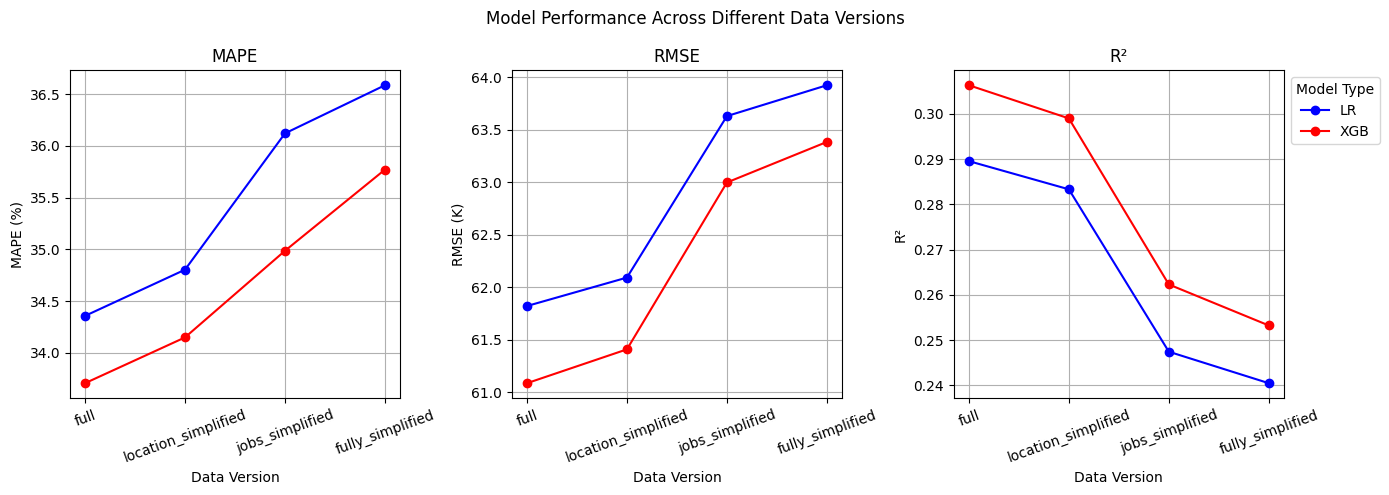

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define colors for models
model_colors = {"LR": "blue", "XGB": "red"}

# Map consistent x-axis labels
x_axis_labels = ["full_data", "location_simplified", "jobs_simplified", "fully_simplified"]

# Assign standard x-axis labels to the DataFrame
lr_results_df["Data Version"] = x_axis_labels
xgb_results_df["Data Version"] = x_axis_labels

# Combine results
df_results = pd.concat([lr_results_df, xgb_results_df])

# Define metrics
metrics = ["MAPE", "RMSE", "R²"]
y_labels = ["MAPE (%)", "RMSE (K)", "R²"]
scaling_factors = [1, 1e-3, 1]  # Convert RMSE to thousands (K)

plt.figure(figsize=(14, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)

    for model_type, color in model_colors.items():
        subset = df_results[df_results["Model"].str.startswith(model_type)]
        plt.plot(x_axis_labels, subset[metric] * scaling_factors[i], marker='o', linestyle='-', color=color, label=model_type)

    plt.xlabel("Data Version")
    plt.ylabel(y_labels[i])
    plt.title(metric)  # Only the metric name
    plt.xticks(x_axis_labels, rotation=20)
    plt.grid(True)

# Add a single legend
plt.legend(title="Model Type", loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle("Model Performance Across Different Data Versions")
plt.tight_layout()
plt.show()


Our tests with Linear Regression and XGBoost on different dataset variations clearly indicate that reducing categorical details (job titles, country locations) consistently reduces model performance.

🔍 Key Findings:
1️⃣ Retaining full categorical details results in the best performance.

Highest R² (0.306 with XGBoost, 0.289 with Linear Regression).
Lowest RMSE and MAPE, indicating more accurate salary predictions.
2️⃣ Simplifying locations (countries → continents) has a small negative impact.

Slight increase in RMSE & drop in R².
Conclusion: Countries likely hold some salary-related information, but the loss is minor.
3️⃣ Simplifying job titles (using clusters) results in a bigger performance drop.

Higher RMSE, worse MAPE, and lower R².
Conclusion: Job title granularity is highly relevant for salary prediction.
4️⃣ Fully simplifying both job titles & locations leads to the worst performance.

Likely due to the loss of crucial salary-related variance in the data.


🚀 Conclusion:

📌 Reducing categorical details significantly lowers model explainability (R² decreases).

📌 The more we generalize job titles and locations, the more salary variations we lose.

📌 For the best predictive performance, we should retain as much categorical detail as possible.



linear model

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# חיזוי על נתוני הבדיקה
y_pred_lr = lr_model.predict(X_test_encoded)

# הערכת ביצועי המודל
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr= np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
relative_rmse_lr = (rmse_lr / salary_mean) * 100

print(f"Linear Regression - MAE: {mae_lr:,.2f}, RMSE: {rmse_lr:,.2f}")
print(f"Relative RMSE: {relative_rmse_lr:.2f}%")

print(f"Explained Variance (R^2): {r2_lr:.2f}")


Linear Regression - MAE: 45,789.69, RMSE: 61,996.26
Relative RMSE: 39.24%
Explained Variance (R^2): 0.29


random forest:

In [ ]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
relative_rmse_rf = (rmse_rf / salary_mean) * 100

print(f"Random Forest - MAE: {mae_rf:,.2f}, RMSE: {rmse_rf:,.2f}")
print(f"Explained Variance (R^2): {r2_rf:.2f}")
print(f"Relative RMSE: {relative_rmse_rf:.2f}%")


Random Forest - MAE: 45,000.94, RMSE: 61,155.39
Explained Variance (R^2): 0.30
Relative RMSE: 38.71%


xgboost

In [ ]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
relative_rmse_xgb = (rmse_xgb / salary_mean) * 100

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:,.2f}")
print(f"Explained Variance (R^2): {r2_xgb:.2f}")
print(f"Relative RMSE: {relative_rmse_xgb:.2f}")

XGBoost - MAE: 45008.57, RMSE: 61,182.65
Explained Variance (R^2): 0.30
Relative RMSE: 38.73


In [ ]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb_categorized = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb_categorized = mean_absolute_error(y_test, y_pred_xgb_categorized)
rmse_xgb_categorized = np.sqrt(mean_squared_error(y_test, y_pred_xgb_categorized))
r2_xgb_categorized = r2_score(y_test, y_pred_xgb_categorized)
relative_rmse_xgb_categorized = (rmse_xgb_categorized / salary_mean) * 100

print(f"XGBoost - MAE: {mae_xgb_categorized:.2f}, RMSE: {rmse_xgb_categorized:,.2f}")
print(f"Explained Variance (R^2): {r2_xgb_categorized:.2f}")
print(f"Relative RMSE: {relative_rmse_xgb_categorized:.2f}")

XGBoost - MAE: 45049.51, RMSE: 61,211.58
Explained Variance (R^2): 0.30
Relative RMSE: 38.75


lgb

In [ ]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 63,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.6,
    'verbose': -1
}

# אימון המודל
lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred_lgb = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)


mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
# חישוב MSE
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

# חישוב RMSE ידנית
rmse_lgb = np.sqrt(mse_lgb)

r2_lgb = r2_score(y_test, y_pred_lgb)
relative_rmse_lgb = (rmse_lgb / salary_mean) * 100

print(f"LightLGB - MAE: {mae_lgb:,.2f}, RMSE: {rmse_lgb:,.2f}")
print(f"Explained Variance (R^2): {r2_lgb:.2f}")
print(f"Relative RMSE: {relative_rmse_lgb:.2f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[90]	training's rmse: 60698.4	valid_1's rmse: 59446.7
LightLGB - MAE: 44,795.27, RMSE: 59,446.65
Explained Variance (R^2): 0.32
Relative RMSE: 37.62


Chosen

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[83]	training's rmse: 60669.5	valid_1's rmse: 59417.1


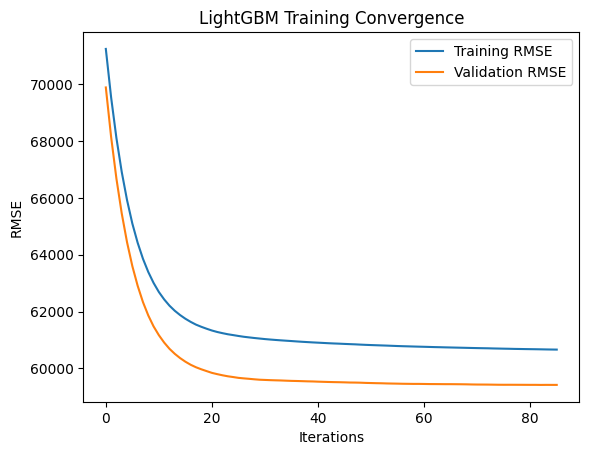

In [ ]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

# יצירת מודל LGBMRegressor
LGBMRegressor_model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

# אימון המודל תוך מעקב אחרי סט אימות
LGBMRegressor_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


              Feature    Importance
2           job_title  3.269879e+14
0    experience_level  1.204860e+14
3  employee_residence  8.261739e+13
4        remote_ratio  1.244842e+13
5    company_location  1.062676e+13
6        company_size  3.145022e+12
1     employment_type  2.046168e+12


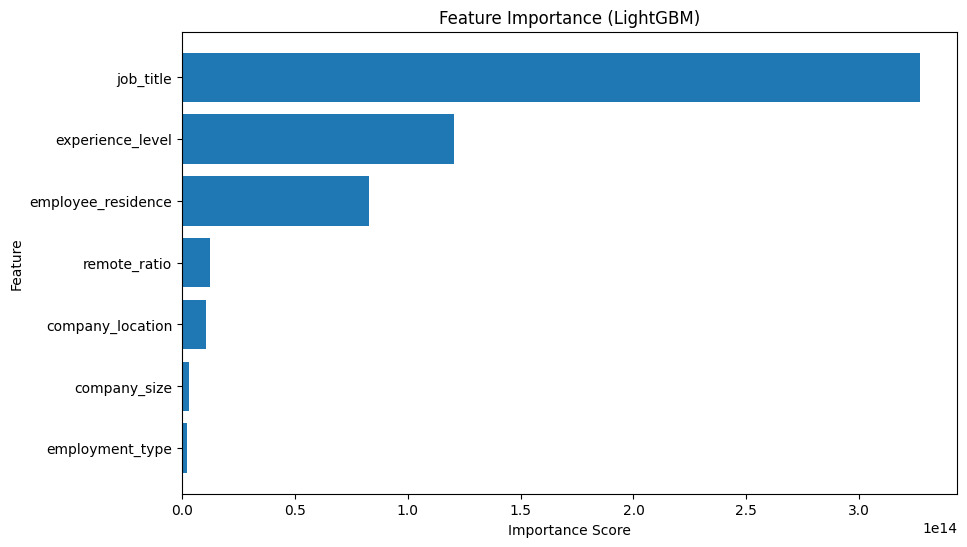

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# קבלת חשיבות הפיצ'רים (אפשר לבחור 'gain' או 'split')
importance = lgbm_model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# יצירת טבלה עם תוצאות
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# הצגת 10 הפיצ'רים הכי חשובים
print(importance_df.head(10))

# ציור גרף החשיבות
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()


              Feature  MI Score
2           job_title  0.447079
7        job_category  0.185401
0    experience_level  0.182259
3  employee_residence  0.158460
5    company_location  0.156215
4        remote_ratio  0.081996
6        company_size  0.066355
1     employment_type  0.008634


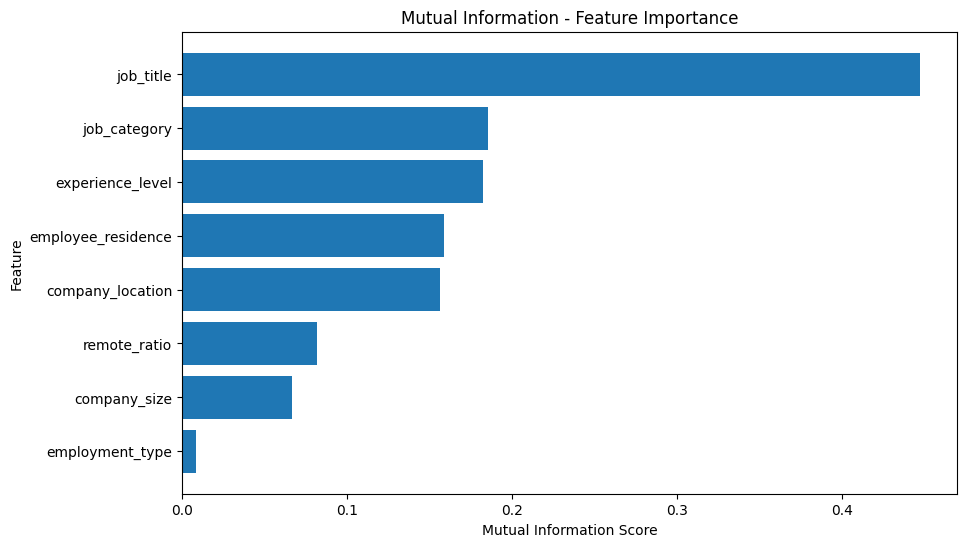

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[138]	training's rmse: 61100.3	valid_1's rmse: 59718.1


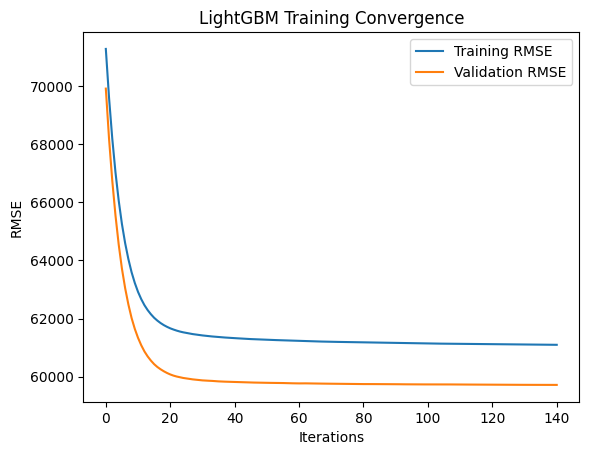

In [ ]:
# נשמור רק את הפיצ'רים שה-MI שלהם גדול מ-0.1
selected_features = mi_df[mi_df["MI Score"] > 0.1]["Feature"].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# אימון המודל מחדש

LGBMRegressor_model.fit(
    X_train_selected, y_train,
    eval_set=[(X_train_selected, y_train), (X_test_selected, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# חישוב ממוצע, חציון וסטיית תקן של השכר לכל מקצוע
job_salary_stats = data.groupby("job_title")["salary_in_usd"].agg(["mean", "median", "std", "count"])

# עיגול כל הערכים ל-0 ספרות אחרי הנקודה
job_salary_stats = job_salary_stats.round(0)

# מיון לפי סטיית תקן בסדר יורד
job_salary_stats = job_salary_stats.sort_values(by="std", ascending=False)

# הצגת 10 המקצועות עם סטיית התקן הגבוהה ביותר
print(job_salary_stats.head(20))


                                           mean    median       std  count
job_title                                                                 
Finance Data Analyst                   141934.0   61896.0  157972.0      3
Technical Writer                       168049.0  102000.0  150576.0     19
AI Engineering Manager                 179930.0  179930.0  125610.0      2
ML Infrastructure Engineer             229300.0  216800.0  124251.0     18
Head of Machine Learning               288701.0  300000.0  123306.0      9
Cloud Developer                        211500.0  211500.0  118087.0      2
Machine Learning Performance Engineer  262500.0  262500.0  116673.0      2
Prompt Engineer                        190413.0  164492.0  113623.0     49
Enterprise Account Executive           257071.0  180000.0  113484.0     14
Machine Learning Tech Lead             183450.0  183450.0  107692.0      2
Deep Learning Engineer                 190808.0  150000.0  106790.0     12
Data Visualization Engine

<ipython-input-49-3fba189e4177>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  job_salary_stats = data.groupby("job_title")["salary_in_usd"].agg(["mean", "median", "std", "count"])


In [ ]:
import pandas as pd

# חישוב כמות הרשומות לכל תפקיד
job_counts = data["job_title"].value_counts()

# רשימת התפקידים שמופיעים לפחות 300 פעמים
jobs_to_keep = job_counts[job_counts >= 1000].index

# יצירת דאטה מסונן עם .copy() כדי למנוע SettingWithCopyWarning
filtered_df = data[data["job_title"].isin(jobs_to_keep)].copy()

# המרת משתנים קטגוריאליים לסוג category
categorical_features = ["job_title", "experience_level", "employment_type", "company_size", "company_location"]
for col in categorical_features:
    filtered_df[col] = filtered_df[col].astype("category")

# הצגת מספר הרשומות לאחר הסינון
print(f"מספר הרשומות אחרי סינון: {filtered_df.shape[0]}")

from sklearn.model_selection import train_test_split
# זיהוי עמודות טקסטואליות

# בחירת משתנים למודל
X = filtered_df.drop(columns=["salary_in_usd"])  # כל המשתנים חוץ מהשכר
y = filtered_df["salary_in_usd"]  # המשתנה המנובא (שכר)

# פיצול לסט אימון וסט בדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# הדפסת גודל הסטים
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


מספר הרשומות אחרי סינון: 63584
Train set size: 50867, Test set size: 12717


In [ ]:
# איתור כל העמודות מסוג object (קטגוריאליות)
categorical_features = filtered_df.select_dtypes(include=["object"]).columns.tolist()

# המרת כל העמודות הקטגוריאליות ל-type 'category'
for col in categorical_features:
    filtered_df[col] = filtered_df[col].astype("category")

# הצגת סוג הנתונים לאחר ההמרה
print(filtered_df.dtypes)


experience_level      category
employment_type       category
job_title             category
salary_in_usd            int64
employee_residence    category
remote_ratio          category
company_location      category
company_size          category
job_category          category
dtype: object


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[132]	training's rmse: 61218.7	valid_1's rmse: 62088.6


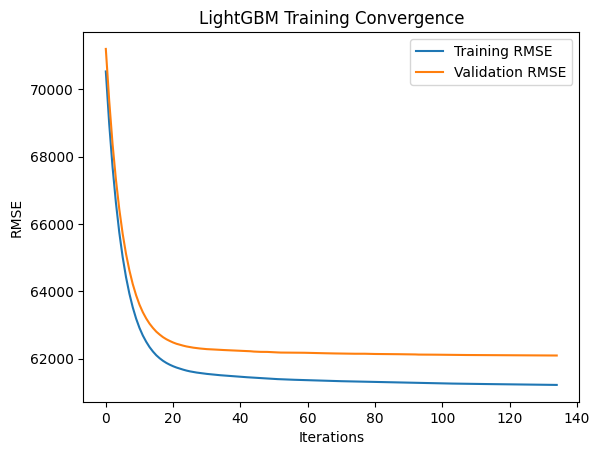

In [ ]:

X = filtered_df.drop(columns=["salary_in_usd"])
y = filtered_df["salary_in_usd"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# יצירת מודל LGBMRegressor
LGBMRegressor_model_2 = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

# אימון המודל תוך מעקב אחרי סט אימות
LGBMRegressor_model_2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model_2.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model_2.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# יצירת עותק של הנתונים עם רעש אקראי
X_train_noisy = X_train + np.random.normal(0, X_train.std() * 0.1, X_train.shape)

# אימון מודל על הדאטה עם רעש
model_noisy = LGBMRegressor()
model_noisy.fit(X_train_noisy, y_train)
y_pred_noisy = model_noisy.predict(X_test)

# חישוב R^2 אחרי הוספת רעש
r2_noisy = r2_score(y_test, y_pred_noisy)
print(f"R^2 after adding noise: {r2_noisy:.4f}")


TypeError: 'Categorical' with dtype category does not support reduction 'std'

In [ ]:
model.save_model('lightgbm_model.txt')


In [ ]:
import pandas as pd
from tabulate import tabulate

# יצירת נתוני דוגמה
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "LightGBM"],
    "MAE": [mae_lr, mae_rf, mae_xgb, mae_lgb],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb, rmse_lgb],
    "R²": [r2_lr, r2_rf, r2_xgb, r2_lgb],
    "Relative RMSE (%)": [relative_rmse_lr, relative_rmse_rf, relative_rmse_xgb, relative_rmse_lgb],
}

# יצירת DataFrame
results_df = pd.DataFrame(results)

# עיגול הנתונים ל-2 ספרות עשרוניות
df_rounded = results_df.copy()
df_rounded["MAE"] = df_rounded["MAE"].round(2)
df_rounded["RMSE"] = df_rounded["RMSE"].round(2)
df_rounded["R²"] = df_rounded["R²"].round(3)  # ערך קטן יותר, מדויק יותר
df_rounded["Relative RMSE (%)"] = df_rounded["Relative RMSE (%)"].round(2)

# הדפסת הטבלה המעוגלת
print(tabulate(df_rounded, headers="keys", tablefmt="pretty"))


+---+-------------------+----------+----------+-------+-------------------+
|   |       Model       |   MAE    |   RMSE   |  R²   | Relative RMSE (%) |
+---+-------------------+----------+----------+-------+-------------------+
| 0 | Linear Regression | 45789.69 | 61996.26 | 0.286 |       39.24       |
| 1 |   Random Forest   | 45000.94 | 61155.39 | 0.305 |       38.71       |
| 2 |      XGBoost      | 45008.57 | 61182.65 | 0.304 |       38.73       |
| 3 |     LightGBM      | 44907.41 | 61006.69 | 0.308 |       38.62       |
+---+-------------------+----------+----------+-------+-------------------+


In [ ]:
df_rounded.to_csv("model_comparison_results.csv", index=False)


Similar results- now take only jobs with >= 50 entries

In [ ]:

# הפרדת משתנים תלויים ובלתי תלויים
X = filtered_data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = filtered_data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


In [ ]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
r2 = r2_score(y_test, y_pred_rf)
print(f"Explained Variance (R^2): {r2:.2f}")


Random Forest - MAE: 42060.22, RMSE: 55424.37
Explained Variance (R^2): 0.23


In [ ]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)


XGBoost - MAE: 41986.65, RMSE: 55327.50
Explained Variance (R^2): 0.24


In [ ]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)
print(f"Explained Variance (R^2): {r2:.2f}")


XGBoost - MAE: 42332.03, RMSE: 56043.78
Explained Variance (R^2): 0.22


In [ ]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# אימון המודל
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# חישוב MSE
mse = mean_squared_error(y_test, y_pred)

# חישוב RMSE ידנית
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance (R^2): {r2:.2f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[142]	training's rmse: 54362	valid_1's rmse: 54834.2
Mean Squared Error: 3006787157.72
Root Mean Squared Error: 54834.18
Explained Variance (R^2): 0.25


Relative RMSE: 37.07%


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# יצירת דאטה ל-LightGBM עם free_raw_data=False
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    reference=train_data,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

# פונקציה להרצת ניסויים
def run_lgb_experiment(params_list, train_data, test_data, X_test, y_test):
    results = []
    for params in params_list:
        # אימון המודל
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=10)]
        )

        # חיזוי
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # הערכת הביצועים
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # שמירת התוצאה
        results.append({
            'params': params,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })

    return results

# רשימת פרמטרים לניסוי
params_list = [
    {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': lr,
        'num_leaves': leaves,
        'min_data_in_leaf': min_data,
        'feature_fraction': feature_frac,
        'bagging_fraction': bagging_frac,
        'verbose': -1
    }
    for lr in [0.01, 0.05, 0.1]  # ניסוי עם Learning Rate משתנה
    for leaves in [15, 31, 63]  # מספר עלים
    for min_data in [20, 50, 100]  # מינימום דוגמאות בכל עלה
    for feature_frac in [0.6, 0.8, 1.0]  # אחוז פיצ'רים
    for bagging_frac in [0.6, 0.8, 1.0]  # אחוז דוגמאות
]

# הרצת הניסוי
results = run_lgb_experiment(params_list, train_data, test_data, X_test, y_test)

# הדפסת התוצאות הטובות ביותר
best_result = min(results, key=lambda x: x['rmse'])
print("Best Parameters:")
print(best_result['params'])
print(f"RMSE: {best_result['rmse']:.2f}, R^2: {best_result['r2']:.2f}")
